In [4302]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV, Lasso, LassoCV
from sklearn.decomposition import PCA

import seaborn as sns

%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

warnings.filterwarnings('ignore')

#### Datasets

In [4303]:
import os
for dirname, _, filenames in os.walk('./input/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
 

./input/real_estate_price_prediction_moscow\gb_submit.csv
./input/real_estate_price_prediction_moscow\sample_submission.csv
./input/real_estate_price_prediction_moscow\test.csv
./input/real_estate_price_prediction_moscow\train.csv


In [4304]:
    TRAIN_DATASET_PATH = './input/real_estate_price_prediction_moscow/train.csv'
    TEST_DATASET_PATH = './input/real_estate_price_prediction_moscow/test.csv'

#### Auxiliary functions

In [4305]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 4)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 4)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [4306]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

#### Loading Train and Test

In [4307]:
train_df = pd.read_csv(TRAIN_DATASET_PATH, sep=',')
test_df = pd.read_csv(TEST_DATASET_PATH, sep=',')

train_df = reduce_mem_usage(train_df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


In [4308]:
print(f'Strings in train: {train_df.shape[0]}')
print(f'Strings in test: {test_df.shape[0]}')

Strings in train: 10000
Strings in test: 5000


In [4309]:
# check the number of columns (train have col=Price --> target)
train_df.shape[1] - test_df.shape[1] == 1

True

#### Target distribution

In [4310]:
train_df.head(3)
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.0000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315720,37.199665,6.273300,8.526700,12.6094,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.937500
std,4859.01902,43.587592,0.839522,21.058716,86.241219,28.560839,5.241148,6.7762,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.519470,1.493601,4.806341,92872.273438
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.0000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,4169.50000,20.000000,1.000000,41.774879,22.769833,1.000000,4.000000,9.0000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,8394.50000,36.000000,2.000000,52.513309,32.781261,6.000000,7.000000,13.0000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,12592.50000,75.000000,2.000000,65.900627,45.128803,9.000000,12.000000,17.0000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,16798.00000,209.000000,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.0000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


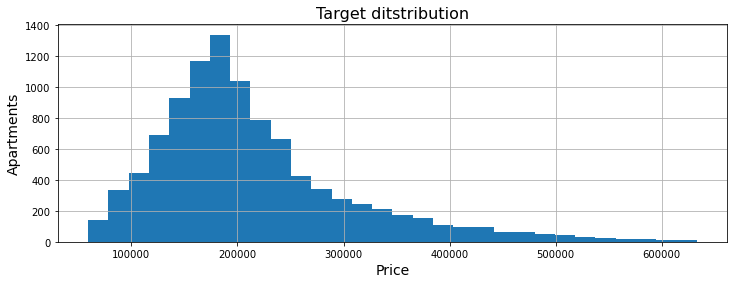

In [4311]:
plt.figure(figsize=(12, 4))
train_df['Price'].hist(bins=30)
plt.xlabel('Price', fontsize=14)
plt.ylabel('Apartments', fontsize=14)
plt.title('Target ditstribution', fontsize=16)

plt.show()

#### Correlation

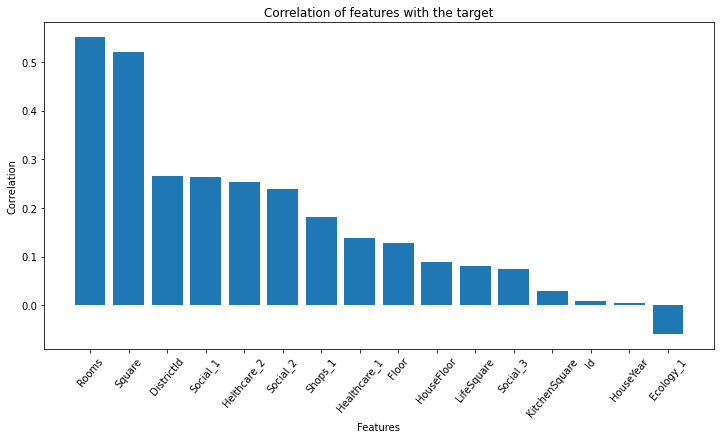

In [4312]:
correlation = train_df.corrwith(train_df['Price']).sort_values(ascending=False)
correlation.drop('Price', inplace=True)

plt.figure(figsize=(12, 6))
plt.bar(correlation.index, correlation)
plt.xticks(rotation=50)
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.title('Correlation of features with the target')

plt.show()

In [4313]:
train_df[train_df['Square'] < train_df['LifeSquare']].shape

(482, 20)

In [4314]:
train_df[train_df['HouseFloor'] < train_df['Floor']].shape

(1825, 20)

### DataPreprocessor

In [4315]:
class DataPreprocessor:
    
    def __init__(self):
        self.medians = None
        self.min_kitchen_square = None
        self.districts_healthcare = None
        self.mean_h1_district = None
        self.med_kitchen_district = None
        self.med_life_sq_dist_rm = None

    
    def fit(self, X):
        # Medians, means, min
        self.medians = X.median()
        
        self.min_kitchen_square = np.quantile(X['KitchenSquare'], q=0.001)

        self.mean_h1_district = X.groupby('DistrictId')['Healthcare_1'].mean().to_dict()
        
        self.med_kitchen_district = X.groupby('DistrictId')['KitchenSquare'].median().to_dict()
        
        self.med_life_sq_dist_rm = X.groupby(['DistrictId', 'Rooms'], as_index=False)['LifeSquare'].median()\
        .rename(columns={'LifeSquare': 'life_id_room_median'})
        
    def transform(self, X):
        # LifeSquare
        
        ## add column with median LifeSquare by DistrictId and Rooms
        X = X.merge(self.med_life_sq_dist_rm, on=['DistrictId', 'Rooms'], how='left')
        
        condition_life = X['LifeSquare'].isna()
        ## NaN --> LifeSquare = life_id_room_median
        X.loc[condition_life, 'LifeSquare'] = X.loc[condition_life, 'life_id_room_median']

        ## NaN (if 'life_id_room_median' = NaN) --> 0.92 * Square - Kitchen
        X['LifeSquare'].fillna(X['Square'] * .92 - X['KitchenSquare'], inplace=True)

        
        # Rooms
        condition_rooms = (X['Rooms'] > 6) | (X['Rooms'] == 0)
        
        ## Square of the room
        room_sq_median =  X['LifeSquare'].median() / self.medians['Rooms']
        X.loc[condition_rooms, 'Rooms'] =  X.loc[condition_rooms, 'LifeSquare'] / room_sq_median

        
        # Square

        ## Square < KitchenSquare --> Square <=> KitchenSquare (if KitchenSquare <= 250 (--> for Square this max))
        X['Square'], X['KitchenSquare'] = np.where(
            (X['Square'] <= X['KitchenSquare']) & (X['KitchenSquare'] <= 250),
            (X['KitchenSquare'], X['Square']), (X['Square'], X['KitchenSquare'])
        )

        ## Square < LifeSquare --> Square <=> LifeSquare 
        X['Square'], X['LifeSquare'] = np.where(
            X['Square'] < X['LifeSquare'], (X['LifeSquare'], X['Square']), (X['Square'], X['LifeSquare'])
        )
        
        
        # KitchenSquare
        ## Outliers --> Square - LifeSquare - 3
        condition_kitchen_square = (X['KitchenSquare'] > 60) | (X['KitchenSquare'] < self.min_kitchen_square)

        X.loc[condition_kitchen_square, 'KitchenSquare'] = \
        X.loc[condition_kitchen_square, 'Square'] - X.loc[condition_kitchen_square, 'LifeSquare'] - 3
        
        
        # Ecology and Shops
        ## Switch to binary
        binary_to_numbers = {'A': 0, 'B': 1}
        
        X.replace({
            'Ecology_2': binary_to_numbers,
            'Ecology_3': binary_to_numbers,
            'Shops_2': binary_to_numbers
        }, inplace=True)
        
        
        # Floor
        ## Min Floor
        train_df.loc[train_df['Floor'] < 1, 'Floor'] = 1
        
        
        # HouseFloor
        ## HouseFloor < Floor --> HouseFloor = Floor
        condition_house_floor = X['HouseFloor'] < X['Floor'] 
        X.loc[condition_house_floor, 'HouseFloor'] = X.loc[condition_house_floor, 'Floor']


        # HouseYear
        ## HouseYear > current year --> median year
        condition_year = X['HouseYear'] > 2020
        X.loc[condition_year, 'HouseYear'] = self.medians['HouseYear']
        
        
        # Healthcare_1
        X.loc[X['Healthcare_1'].isna(), 'Healthcare_1'] = X['DistrictId'].map(self.mean_h1_district)
        X['Healthcare_1'].fillna(self.medians['Healthcare_1'], inplace=True)
        healthcare_1_quntile_max = np.quantile(X['Healthcare_1'], q=0.9)
        X.loc[X['Healthcare_1'] > healthcare_1_quntile_max, 'Healthcare_1'] = healthcare_1_quntile_max
    
    
        # remove cols
        X.drop(columns=['Id', 'life_id_room_median'], inplace=True)
    
    
        # Fillna
        X.fillna(self.medians, inplace=True)

    
        return X

### FeatureGenerator

In [4316]:
class FeatureGenerator:
    
    def __init__(self):
        self.district_median_year = None
        self.district_density = None
        self.district_price_per_square = None
        self.min_square = None
        self.max_square = None
        self.district_size = None
        self.median_district_size = None
    
    def fit(self, X, y=None):
        X = X.copy()
        
        self.district_size = X['DistrictId'].value_counts().reset_index() \
        .rename(columns={'index': 'DistrictId', 'DistrictId': 'DistrictSize'})
        
        self.median_district_size = self.district_size['DistrictSize'].median()
        
        self.districts_median_year = X.groupby('DistrictId')['HouseYear'].median().to_dict()
        self.district_square = X.groupby('DistrictId')['Square'].median().to_dict()        

        self.min_square = np.quantile(X['Square'], q=0.005)
        self.max_square = np.quantile(X['Square'], q=0.995)

        # Target encoding
        if y is not None:
            df = X.copy()
            df['Price'] = y.values
            
            self.district_price_per_square = \
            df.groupby('DistrictId')['Price'].median() / df.groupby('DistrictId')['Square'].median()

        
        
    def transform(self, X):
        # DistrictSize
        X = X.merge(self.district_size, on='DistrictId', how='left')
        X.loc[X['DistrictSize'].isna(), 'DistrictSize'] = self.median_district_size
        
        # DistrictYear
        X['DistrictYear'] = X['DistrictId'].map(self.districts_median_year)
        
        self.median_district_year = X['DistrictYear'].median()
        X['DistrictYear'].fillna(self.median_district_year, inplace=True)
        
        # DistrictSquare
        X['DistrictSquare'] = X['DistrictId'].map(self.district_square)
        
        self.median_district_square = X['DistrictId'].median()
        X['DistrictSquare'].fillna(self.median_district_square, inplace=True)
        
        # DistrictPrice
        self.district_price_per_square.to_dict()
        X['DistrictPrice'] = X['DistrictId'].map(self.district_price_per_square)
        
        self.median_district_price_per_square = X['DistrictPrice'].median()
        X['DistrictPrice'].fillna(self.median_district_price_per_square, inplace=True)
        
        # Floor_cat
        floor_bins = [0, 4, 7, 12, X['Floor'].max()]
        X['Floor_cat'] = pd.cut(X['Floor'], bins=floor_bins, labels=False)
        X['Floor_cat'].fillna(-1, inplace=True)
        
        # Scaler
        scaler = RobustScaler()
        pca = PCA(n_components=1, random_state=42)
        social_scale = pd.DataFrame(scaler.fit_transform(X[['Social_1', 'Social_2', 'Social_3']])) 
        # Social
        X['Social'] = pca.fit_transform(social_scale)
        
        return X
    
    
    def drop_outliers(self, X, y=None):
        X['Price'] = y.values
        X = X.loc[(X['Square'] > self.min_square) & (X['Square'] < self.max_square)]
        y = X['Price']
        X.drop(columns='Price', inplace=True)
        return X, y
    
    

### 5. Feature selection

### 6. Splitting into train / test

In [4317]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [4318]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.15, shuffle=True, random_state=21)

In [4319]:
preprocessor = DataPreprocessor()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((8500, 18), (1500, 18), (5000, 18))

In [4320]:
X_train.shape

(8500, 18)

In [4321]:
features_gen = FeatureGenerator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
#X_train, y_train = features_gen.drop_outliers(X_train, y_train)

X_valid = features_gen.transform(X_valid)

test_df = features_gen.transform(test_df)

X_train.columns.to_list()

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'DistrictSize',
 'DistrictYear',
 'DistrictSquare',
 'DistrictPrice',
 'Floor_cat',
 'Social']

In [4322]:
X_train['Social'].describe()

count    8.500000e+03
mean    -8.544799e-17
std      4.769832e+00
min     -1.621125e+00
25%     -1.607137e+00
50%     -1.210660e+00
75%     -6.099136e-01
max      2.659162e+01
Name: Social, dtype: float64

In [4323]:
feature_names = [
    'Rooms',
    'Square',
    'LifeSquare',
    'KitchenSquare',
    'HouseFloor',
    'HouseYear',
    'Ecology_1',
    'Social_1',
    'Social_2',
    'Social_3',
    'Healthcare_1',
    #'Shops_1'
]

new_feature_names = [
    'DistrictSize',
    'DistrictYear',
    'DistrictSquare',
    'DistrictPrice',
    #'Social'
]

target_name = 'Price'

# Elimination: 'Ecology_2', 'Ecology_3', 'Shops_2', 'Helthcare_2', 'Floor', 'Floor_cat'

In [4324]:
X_train.shape, X_valid.shape, test_df.shape

((8500, 24), (1500, 24), (5000, 24))

In [4325]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [4326]:
X_train.isna().sum().sum(), X_test.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

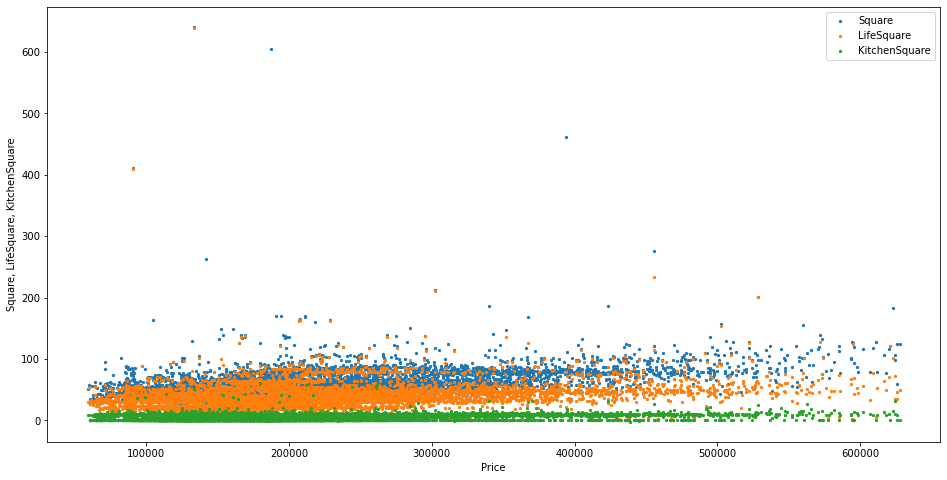

In [4327]:
# Square, LifeSqure, KitchenSquare
TypeSquares = ['Square', 'LifeSquare', 'KitchenSquare']

plt.figure(figsize=(16, 8))

for feature in TypeSquares:
    plt.scatter(y_train, X_train[feature], label=feature, s=5)

plt.xlabel('Price')
plt.ylabel('Square, LifeSquare, KitchenSquare')
plt.legend()
plt.show()

### 7. Building a model

In [4328]:
# cv_score = cross_val_score(gb_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
# cv_score

In [4329]:
#cv_score.mean()

In [4330]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

Train R2:	0.9307
Test R2:	0.7703


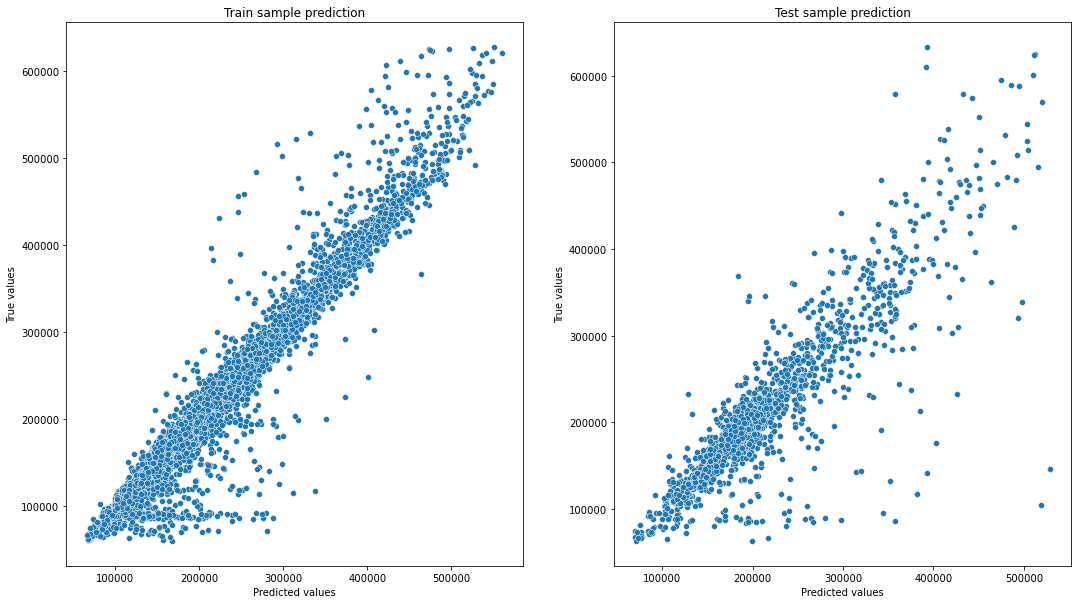

In [4331]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=18,
                                     min_samples_leaf=7, 
                                     n_estimators=155, 
                                     max_features='sqrt', 
                                     loss='huber',
                                     random_state=42,
                                     learning_rate=0.025)

gb_model.fit(X_train, y_train)

y_train_preds = gb_model.predict(X_train)
y_valid_preds = gb_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_valid_preds)

In [4332]:
feature_importances = pd.DataFrame(zip(X_train.columns, gb_model.feature_importances_), columns=['feature_name', 'importance'])
feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.272370
14,DistrictPrice,0.114501
0,Rooms,0.109541
11,DistrictSize,0.085257
2,LifeSquare,0.084597
8,Social_2,0.059625
7,Social_1,0.054505
9,Social_3,0.040088
3,KitchenSquare,0.035652
5,HouseYear,0.035641


### 8. Prediction on test dataset

In [4333]:
test_df.shape

(5000, 15)

In [4334]:
submit = pd.read_csv('./input/real_estate_price_prediction_moscow/sample_submission.csv')

In [4335]:
predictions = gb_model.predict(test_df)
predictions

array([161199.02490655, 119077.95781411, 142515.0046218 , ...,
       153180.457629  , 191206.83748239, 291664.60393293])

In [4336]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,161199.024907
1,5925,119077.957814
2,960,142515.004622
3,3848,117509.398565
4,746,189664.139545


In [4337]:
submit.to_csv('./input/real_estate_price_prediction_moscow/gb_submit.csv', index=False)